In [1]:
import pandas as pd
import numpy as np

flight_df = pd.read_csv('../data/Flight Level Data.csv')
pnr_df = pd.read_csv('../data/PNR+Flight+Level+Data.csv')
remarks_df = pd.read_csv('../data/PNR Remark Level Data.csv')
bags_df = pd.read_csv('../data/Bag+Level+Data.csv')
airports_df = pd.read_csv('../data/Airports Data.csv')

print(f"Flights: {flight_df.shape}")
print(f"PNR: {pnr_df.shape}")
print(f"Remarks: {remarks_df.shape}")
print(f"Bags: {bags_df.shape}")
print(f"Airports: {airports_df.shape}")


Flights: (8099, 15)
PNR: (687878, 12)
Remarks: (51698, 4)
Bags: (687245, 8)
Airports: (5612, 2)


In [2]:
print(flight_df.columns)
print(pnr_df.columns)
print(remarks_df.columns)
print(bags_df.columns)


Index(['company_id', 'flight_number', 'scheduled_departure_date_local',
       'scheduled_departure_station_code', 'scheduled_arrival_station_code',
       'scheduled_departure_datetime_local',
       'scheduled_arrival_datetime_local', 'actual_departure_datetime_local',
       'actual_arrival_datetime_local', 'total_seats', 'fleet_type', 'carrier',
       'scheduled_ground_time_minutes', 'actual_ground_time_minutes',
       'minimum_turn_minutes'],
      dtype='object')
Index(['company_id', 'flight_number', 'scheduled_departure_date_local',
       'scheduled_departure_station_code', 'scheduled_arrival_station_code',
       'record_locator', 'pnr_creation_date', 'total_pax', 'is_child',
       'basic_economy_ind', 'is_stroller_user', 'lap_child_count'],
      dtype='object')
Index(['record_locator', 'pnr_creation_date', 'flight_number',
       'special_service_request'],
      dtype='object')
Index(['company_id', 'flight_number', 'scheduled_departure_date_local',
       'scheduled_depa

In [3]:
# Clean column names and convert dates/datetimes
import pandas as pd
import numpy as np

# Strip any accidental spaces
for df in [flight_df, pnr_df, remarks_df, bags_df]:
    df.columns = df.columns.str.strip()

# Convert datetime and date columns
datetime_cols = [c for c in flight_df.columns if 'datetime' in c]
for c in datetime_cols:
    flight_df[c] = pd.to_datetime(flight_df[c], errors='coerce')

date_cols = ['scheduled_departure_date_local', 'pnr_creation_date', 'bag_tag_issue_date']
for df in [flight_df, pnr_df, bags_df, remarks_df]:
    for c in df.columns:
        if any(x in c for x in ['date_local', 'issue_date', 'creation_date']):
            df[c] = pd.to_datetime(df[c], errors='coerce').dt.date


In [4]:
pnr_agg = pnr_df.groupby(
    ['company_id', 'flight_number', 'scheduled_departure_date_local']
).agg(
    total_pax=('total_pax', 'sum'),
    lap_child_count=('lap_child_count', 'sum'),
    stroller_users=('is_stroller_user', 'sum'),
    basic_economy_pax=('basic_economy_ind', 'sum'),
    child_pax=('is_child', 'sum')
).reset_index()


In [5]:
bag_agg = bags_df.groupby(
    ['company_id', 'flight_number', 'scheduled_departure_date_local']
).agg(
    total_bags=('bag_tag_unique_number', 'count'),
    transfer_bags=('bag_type', lambda x: (x.str.lower() == 'transfer').sum()),
    checked_bags=('bag_type', lambda x: (x.str.lower() == 'checked').sum())
).reset_index()


In [6]:
remarks_agg = remarks_df.groupby(
    ['flight_number']
).agg(
    special_service_requests=('special_service_request', 'count')
).reset_index()


In [7]:
master_df = (flight_df
    .merge(pnr_agg, on=['company_id', 'flight_number', 'scheduled_departure_date_local'], how='left')
    .merge(bag_agg, on=['company_id', 'flight_number', 'scheduled_departure_date_local'], how='left')
    .merge(remarks_agg, on='flight_number', how='left')
)


In [27]:


# --- 1️⃣ Clean PNR flags before aggregation ---
flag_cols = ['is_child', 'basic_economy_ind', 'is_stroller_user']

for col in flag_cols:
    if col in pnr_df.columns:
        pnr_df[col] = (
            pnr_df[col]
            .astype(str)
            .str.upper()
            .str.strip()
            .map({'Y': 1, 'N': 0})
            .fillna(0)
            .astype(int)
        )

# --- 2️⃣ Aggregate PNR data at flight level ---
pnr_agg = (
    pnr_df.groupby(
        ['company_id', 'flight_number', 'scheduled_departure_date_local'],
        as_index=False
    )
    .agg(
        total_pax=('total_pax', 'sum'),
        lap_child_count=('lap_child_count', 'sum'),
        stroller_users=('is_stroller_user', 'sum'),
        basic_economy_pax=('basic_economy_ind', 'sum'),
        child_pax=('is_child', 'sum')
    )
)


# Aggregate bags per flight
bag_agg = (
    bags_df.groupby(
        ['company_id', 'flight_number', 'scheduled_departure_date_local'],
        as_index=False
    )
    .agg(
        total_bags=('bag_tag_unique_number', 'count'),
        transfer_bags=('bag_type', lambda x: x.str.strip().str.lower().eq('transfer').sum()),
        checked_bags=('bag_type', lambda x: x.str.strip().str.lower().eq('checked').sum())
    )
)

bag_agg['transfer_to_total_ratio'] = bag_agg['transfer_bags'] / bag_agg['total_bags']

average_ratio = bag_agg['transfer_to_total_ratio'].mean()
print("Average transfer-to-total bag ratio:", average_ratio)




# --- 4️⃣ Aggregate PNR Remarks data ---
remarks_agg = (
    remarks_df.groupby('flight_number', as_index=False)
    .agg(special_service_requests=('special_service_request', 'count'))
)

# --- 5️⃣ Merge all aggregated tables into master_df ---
master_df = (
    flight_df
    .merge(pnr_agg, on=['company_id', 'flight_number', 'scheduled_departure_date_local'], how='left')
    .merge(bag_agg, on=['company_id', 'flight_number', 'scheduled_departure_date_local'], how='left')
    .merge(remarks_agg, on='flight_number', how='left')
)

# --- 6️⃣ Fill missing values with 0 (for numeric columns) ---
num_cols = master_df.select_dtypes(include=['number']).columns
master_df[num_cols] = master_df[num_cols].fillna(0)

print(f"✅ Merged dataset shape: {master_df.shape}")
display(master_df.head())


Average transfer-to-total bag ratio: 0.5919523266374898
✅ Merged dataset shape: (8099, 25)


,company_id,flight_number,scheduled_departure_date_local,scheduled_departure_station_code,scheduled_arrival_station_code,scheduled_departure_datetime_local,scheduled_arrival_datetime_local,actual_departure_datetime_local,actual_arrival_datetime_local,total_seats,...,total_pax,lap_child_count,stroller_users,basic_economy_pax,child_pax,total_bags,transfer_bags,checked_bags,transfer_to_total_ratio,special_service_requests
0,OO,4792,2025-08-04,ORD,ROA,2025-08-04 17:57:00+00:00,2025-08-04 21:04:00+00:00,2025-08-04 18:04:00+00:00,2025-08-04 20:52:00+00:00,76,...,65,0,0,0,0,42,20,0,0.476190,41
1,UA,920,2025-08-03,ORD,LHR,2025-08-03 18:05:00+00:00,2025-08-04 08:20:00+00:00,2025-08-03 18:27:00+00:00,2025-08-04 08:06:00+00:00,167,...,171,1,0,0,0,143,37,0,0.258741,60
2,UA,1776,2025-08-10,ORD,PHL,2025-08-10 18:20:00+00:00,2025-08-10 21:35:00+00:00,2025-08-10 20:11:00+00:00,2025-08-10 23:26:00+00:00,166,...,180,0,0,0,0,85,38,0,0.447059,41
3,OO,5790,2025-08-06,ORD,CRW,2025-08-06 18:20:00+00:00,2025-08-06 21:04:00+00:00,2025-08-06 20:05:00+00:00,2025-08-06 22:42:00+00:00,50,...,55,0,0,0,0,54,40,0,0.740741,30
4,UA,1398,2025-08-05,ORD,ATL,2025-08-05 18:20:00+00:00,2025-08-05 21:29:00+00:00,2025-08-05 18:16:00+00:00,2025-08-05 21:49:00+00:00,166,...,136,0,0,0,0,70,51,0,0.728571,96


In [28]:
print(bags_df['bag_type'].unique())


['Transfer' 'Origin' 'Hot Transfer']


In [32]:
master_df['departure_delay_min'] = (
    (pd.to_datetime(master_df['actual_departure_datetime_local'])
     - pd.to_datetime(master_df['scheduled_departure_datetime_local']))
    .dt.total_seconds() / 60
)

master_df['arrival_delay_min'] = (
    (pd.to_datetime(master_df['actual_arrival_datetime_local'])
     - pd.to_datetime(master_df['scheduled_arrival_datetime_local']))
    .dt.total_seconds() / 60
)

master_df['delay_flag'] = (master_df['departure_delay_min'] > 0).astype(int)

# --- 2️⃣ Ground-time pressure ---
master_df['ground_time_ratio'] = (
    master_df['scheduled_ground_time_minutes'] /
    master_df['minimum_turn_minutes']
).replace([np.inf, -np.inf], np.nan)

# --- 3️⃣ Bag mix (updated) ---
master_df['transfer_bag_ratio'] = master_df['transfer_bags'] / master_df['total_bags']
master_df['transfer_bag_ratio'] = master_df['transfer_bag_ratio'].fillna(0)



# --- 4️⃣ Passenger load metrics ---
master_df['load_factor'] = (
    master_df['total_pax'] / master_df['total_seats']
).replace([np.inf, -np.inf], np.nan)

# --- 5️⃣ Service intensity ---
master_df['ssr_per_pax'] = (
    master_df['special_service_requests'] / master_df['total_pax']
).replace([np.inf, -np.inf], 0)

# --- 6️⃣ Normalize NA values ---
feature_cols = [
    'departure_delay_min', 'arrival_delay_min', 'delay_flag',
    'ground_time_ratio', 'transfer_bag_ratio', 'load_factor', 'ssr_per_pax'
]
master_df[feature_cols] = master_df[feature_cols].fillna(0)

print("✅ Feature engineering complete.")
display(master_df[[
    'flight_number', 'scheduled_departure_date_local',
    'departure_delay_min', 'ground_time_ratio',
    'transfer_bag_ratio', 'load_factor', 'ssr_per_pax'
]].head())

✅ Feature engineering complete.


,flight_number,scheduled_departure_date_local,departure_delay_min,ground_time_ratio,transfer_bag_ratio,load_factor,ssr_per_pax
0,4792,2025-08-04,7.0,1.235294,0.476190,0.855263,0.630769
1,920,2025-08-03,22.0,1.620690,0.258741,1.023952,0.350877
2,1776,2025-08-10,111.0,1.490196,0.447059,1.084337,0.227778
3,5790,2025-08-06,105.0,7.689655,0.740741,1.100000,0.545455
4,1398,2025-08-05,-4.0,1.470588,0.728571,0.819277,0.705882


Quantitative delay info → minutes late for each flight

Ground-time ratio → < 1 means below minimum turn time

Bag ratios → complexity due to transfer handling

Load factor → fullness of aircraft

SSR per pax → passenger service demand

✈️ Average departure delay: 21.18 minutes
📈 % of flights departing late: 49.6%
🕒 Flights with scheduled ground time ≤ minimum turn mins: 8.1%
🧳 Average transfer-to-total bag ratio: 0.52
👥 Correlation between load factor and delay: -0.150


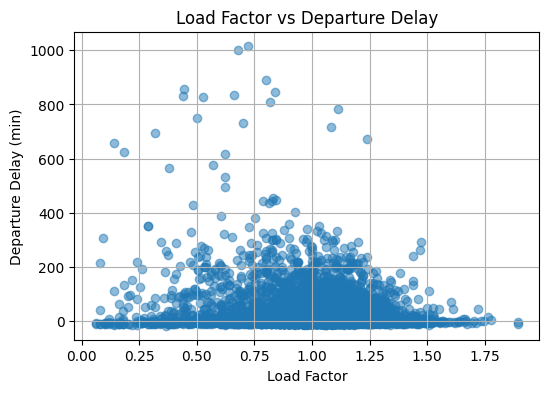

 Correlation between SSR (adjusted for load) and delay: 0.064


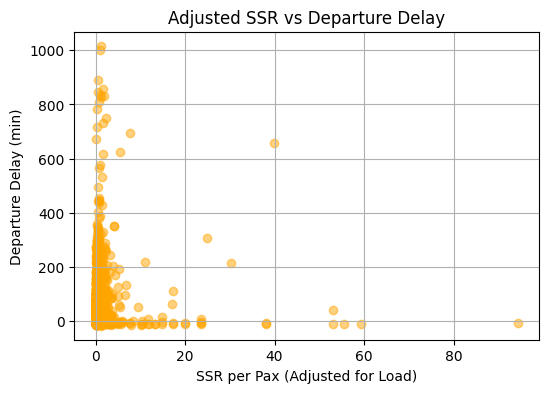


📊 EDA Summary:


,avg_departure_delay_min,pct_late_departures,pct_flights_tight_ground,avg_transfer_to_checked_ratio,corr_load_vs_delay,corr_ssr_adj_vs_delay
0,21.184961,49.611063,8.050377,0.515218,-0.150214,0.064185


In [33]:
import matplotlib.pyplot as plt

# --- 1️⃣ Average delay and % of late departures ---
avg_delay = master_df['departure_delay_min'].mean()
pct_late = (master_df['delay_flag'].mean()) * 100

print(f"✈️ Average departure delay: {avg_delay:.2f} minutes")
print(f"📈 % of flights departing late: {pct_late:.1f}%")

# --- 2️⃣ Flights with ground time close to or below minimum turn mins ---
tight_ground = master_df[master_df['ground_time_ratio'] <= 1]
pct_tight_ground = (len(tight_ground) / len(master_df)) * 100
print(f"🕒 Flights with scheduled ground time ≤ minimum turn mins: {pct_tight_ground:.1f}%")

# --- 3️⃣ Average ratio of transfer bags vs. checked bags ---
master_df['transfer_to_checked_ratio'] = master_df.apply(
    lambda x: x['transfer_bags'] / x['checked_bags'] if x['checked_bags'] > 0 else 0, axis=1
)
avg_bag_ratio = master_df['transfer_bag_ratio'].mean()
print(f"🧳 Average transfer-to-total bag ratio: {avg_bag_ratio:.2f}")


# --- 4️⃣ Passenger load vs operational difficulty (delay proxy) ---
corr_load_delay = master_df['load_factor'].corr(master_df['departure_delay_min'])
print(f"👥 Correlation between load factor and delay: {corr_load_delay:.3f}")

# Plot: load factor vs delay
plt.figure(figsize=(6, 4))
plt.scatter(master_df['load_factor'], master_df['departure_delay_min'], alpha=0.5)
plt.title('Load Factor vs Departure Delay')
plt.xlabel('Load Factor')
plt.ylabel('Departure Delay (min)')
plt.grid(True)
plt.show()

# --- 5️⃣ SSR vs delay controlling for load ---
master_df['ssr_adj'] = master_df['ssr_per_pax'] / (master_df['load_factor'] + 1e-6)
corr_ssr_delay = master_df['ssr_adj'].corr(master_df['departure_delay_min'])
print(f" Correlation between SSR (adjusted for load) and delay: {corr_ssr_delay:.3f}")

# Plot: SSR intensity vs delay
plt.figure(figsize=(6, 4))
plt.scatter(master_df['ssr_adj'], master_df['departure_delay_min'], alpha=0.5, color='orange')
plt.title('Adjusted SSR vs Departure Delay')
plt.xlabel('SSR per Pax (Adjusted for Load)')
plt.ylabel('Departure Delay (min)')
plt.grid(True)
plt.show()

# --- 6️⃣ Summary stats for report ---
eda_summary = {
    "avg_departure_delay_min": avg_delay,
    "pct_late_departures": pct_late,
    "pct_flights_tight_ground": pct_tight_ground,
    "avg_transfer_to_checked_ratio": avg_bag_ratio,
    "corr_load_vs_delay": corr_load_delay,
    "corr_ssr_adj_vs_delay": corr_ssr_delay
}

eda_summary_df = pd.DataFrame([eda_summary])
print("\n📊 EDA Summary:")
display(eda_summary_df)

In [18]:
print(bags_df['bag_type'].value_counts())


bag_type
Transfer        347546
Origin          290121
Hot Transfer     49578
Name: count, dtype: int64


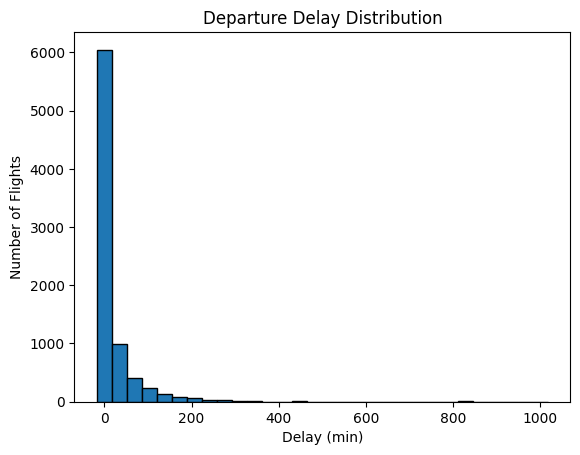

In [34]:
plt.hist(master_df['departure_delay_min'], bins=30, edgecolor='k')
plt.title("Departure Delay Distribution")
plt.xlabel("Delay (min)")
plt.ylabel("Number of Flights")
plt.show()


In [35]:
top_delays = master_df.sort_values('departure_delay_min', ascending=False).head(10)
display(top_delays[['flight_number', 'scheduled_departure_date_local', 'departure_delay_min']])


,flight_number,scheduled_departure_date_local,departure_delay_min
4940,4518,2025-08-12,1017.0
5315,5382,2025-08-11,1000.0
774,4491,2025-08-12,891.0
4451,5251,2025-08-12,859.0
3925,4188,2025-08-12,847.0
3466,5538,2025-08-11,834.0
6900,4507,2025-08-13,831.0
5827,920,2025-08-12,829.0
7159,4792,2025-08-12,811.0
6322,5251,2025-08-15,784.0


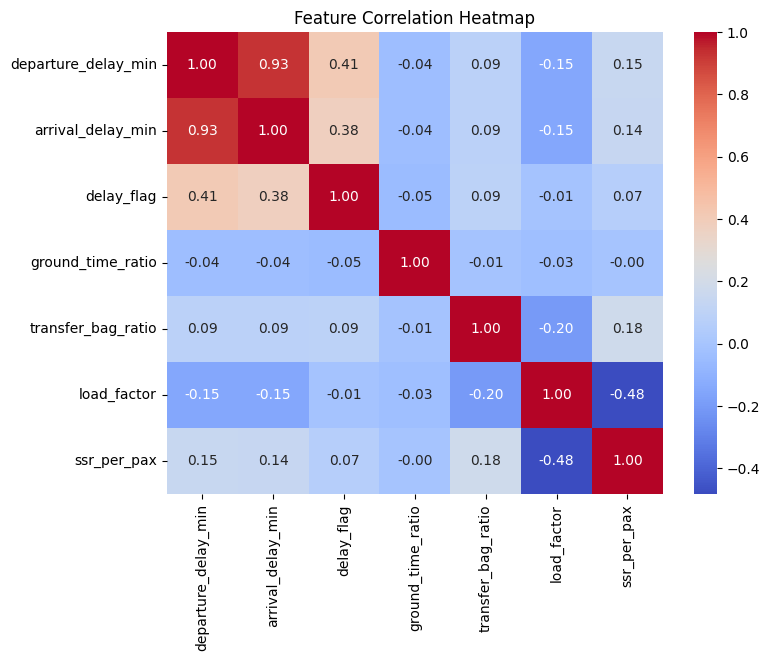

In [36]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(master_df[feature_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# --- 1️⃣ Departure & Arrival Delays ---
master_df['departure_delay_min'] = (
    (pd.to_datetime(master_df['actual_departure_datetime_local'])
     - pd.to_datetime(master_df['scheduled_departure_datetime_local']))
    .dt.total_seconds() / 60
)

master_df['arrival_delay_min'] = (
    (pd.to_datetime(master_df['actual_arrival_datetime_local'])
     - pd.to_datetime(master_df['scheduled_arrival_datetime_local']))
    .dt.total_seconds() / 60
)

master_df['delay_flag'] = (master_df['departure_delay_min'] > 0).astype(int)

# --- 2️⃣ Ground-time pressure ---
master_df['ground_time_ratio'] = (
    master_df['scheduled_ground_time_minutes'] / master_df['minimum_turn_minutes']
).replace([np.inf, -np.inf], np.nan)

# --- 3️⃣ Bag mix (transfer-to-total) ---
master_df['transfer_bag_ratio'] = (
    master_df['transfer_bags'] / master_df['total_bags']
).replace([np.inf, -np.inf], 0)

# --- 4️⃣ Passenger load metrics ---
master_df['load_factor'] = (
    master_df['total_pax'] / master_df['total_seats']
).replace([np.inf, -np.inf], np.nan)

# --- 5️⃣ Service intensity ---
master_df['ssr_per_pax'] = (
    master_df['special_service_requests'] / master_df['total_pax']
).replace([np.inf, -np.inf], 0)

# --- 6️⃣ Normalize NA values ---
feature_cols = [
    'departure_delay_min', 'arrival_delay_min', 'delay_flag',
    'ground_time_ratio', 'transfer_bag_ratio', 'load_factor', 'ssr_per_pax'
]
master_df[feature_cols] = master_df[feature_cols].fillna(0)

# --- 7️⃣ Summary metrics ---
avg_delay = master_df['departure_delay_min'].mean()
pct_late = (master_df['delay_flag'].mean()) * 100
pct_tight_ground = (master_df[master_df['ground_time_ratio'] <= 1].shape[0] / len(master_df)) * 100
avg_bag_ratio = master_df['transfer_bag_ratio'].mean()
corr_load_delay = master_df['load_factor'].corr(master_df['departure_delay_min'])
corr_ssr_delay = (master_df['ssr_per_pax'] / (master_df['load_factor'] + 1e-6)).corr(master_df['departure_delay_min'])

print(f"✈️ Average departure delay: {avg_delay:.2f} minutes")
print(f"📈 % of flights departing late: {pct_late:.1f}%")
print(f"🕒 Flights with scheduled ground time ≤ minimum turn mins: {pct_tight_ground:.1f}%")
print(f"🧳 Average transfer-to-total bag ratio: {avg_bag_ratio:.2f}")
print(f"👥 Correlation between load factor and delay: {corr_load_delay:.3f}")
print(f"📊 Correlation between SSR per pax (adj) and delay: {corr_ssr_delay:.3f}")

✈️ Average departure delay: 21.18 minutes
📈 % of flights departing late: 49.6%
🕒 Flights with scheduled ground time ≤ minimum turn mins: 8.1%
🧳 Average transfer-to-total bag ratio: 0.52
👥 Correlation between load factor and delay: -0.150
📊 Correlation between SSR per pax (adj) and delay: 0.064


Flight Difficulty Score

,flight_number,scheduled_departure_date_local,flight_difficulty_score,difficulty_level
2101,5274,2025-08-10,0.685824,High
774,4491,2025-08-12,0.673738,High
1407,4186,2025-08-12,0.672757,High
3466,5538,2025-08-11,0.666752,High
4940,4518,2025-08-12,0.659961,High
5315,5382,2025-08-11,0.659514,High
7910,5274,2025-08-11,0.650661,High
5309,5253,2025-08-14,0.640565,High
5995,5103,2025-08-13,0.639756,High
6969,5314,2025-08-12,0.639178,High


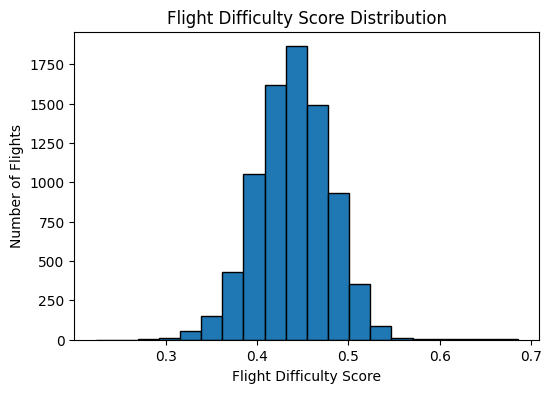

,flight_number,scheduled_departure_date_local,ground_time_ratio,load_factor,transfer_bag_ratio
27,3700,2025-08-02,0.147059,1.052632,0.520000
38,4546,2025-08-06,-0.172414,0.920000,0.714286
51,2177,2025-08-15,0.209302,1.095238,0.755814
63,767,2025-08-13,0.354839,1.010000,0.696203
111,5790,2025-08-01,-0.241379,1.080000,0.586957
...,...,...,...,...,...
7915,4748,2025-08-01,0.103448,1.040000,0.830508
7958,1756,2025-08-02,0.969231,0.975904,0.638298
8058,1756,2025-08-15,0.830769,1.018072,0.620370
8076,5790,2025-08-14,-1.068966,0.940000,0.923077


In [38]:
scaler = MinMaxScaler()
master_df[['norm_delay', 'norm_ground', 'norm_transfer', 'norm_load', 'norm_ssr']] = scaler.fit_transform(
    master_df[['departure_delay_min', 'ground_time_ratio', 'transfer_bag_ratio', 'load_factor', 'ssr_per_pax']]
)

# Invert ground time so lower ground time = higher risk
master_df['norm_ground'] = 1 - master_df['norm_ground']

# --- 2️⃣ Compute Flight Difficulty Score ---
weights = {
    'norm_delay': 0.25,
    'norm_ground': 0.25,
    'norm_transfer': 0.15,
    'norm_load': 0.2,
    'norm_ssr': 0.15
}

master_df['flight_difficulty_score'] = (
    master_df['norm_delay'] * weights['norm_delay'] +
    master_df['norm_ground'] * weights['norm_ground'] +
    master_df['norm_transfer'] * weights['norm_transfer'] +
    master_df['norm_load'] * weights['norm_load'] +
    master_df['norm_ssr'] * weights['norm_ssr']
)

# --- 3️⃣ Categorize flights into Low / Medium / High difficulty ---
master_df['difficulty_level'] = pd.qcut(master_df['flight_difficulty_score'], q=3, labels=['Low','Medium','High'])

# --- 4️⃣ Inspect top difficult flights ---
display(master_df.sort_values('flight_difficulty_score', ascending=False)[[
    'flight_number', 'scheduled_departure_date_local', 'flight_difficulty_score', 'difficulty_level'
]].head(10))

# --- 5️⃣ Optional visualization ---
plt.figure(figsize=(6,4))
plt.hist(master_df['flight_difficulty_score'], bins=20, edgecolor='k')
plt.title('Flight Difficulty Score Distribution')
plt.xlabel('Flight Difficulty Score')
plt.ylabel('Number of Flights')
plt.show()

# =============================
# Step 5: Operational Risk Flag (binary)
# =============================
master_df['operational_risk_flag'] = (
    (master_df['ground_time_ratio'] <= 1.0) &
    (master_df['load_factor'] >= 0.85) &
    (master_df['transfer_bag_ratio'] >= 0.5)
).astype(int)

# Optional: inspect high-risk flights
high_risk_flights = master_df[master_df['operational_risk_flag'] == 1]
display(high_risk_flights[['flight_number', 'scheduled_departure_date_local', 'ground_time_ratio', 'load_factor', 'transfer_bag_ratio']])

In [40]:
# =============================
# Step 6: Flight Summary Table
# =============================
import os

# Create the folder if it doesn't exist
os.makedirs('../outputs', exist_ok=True)
summary_cols = [
    'flight_number',
    'scheduled_departure_date_local',
    'departure_delay_min',
    'ground_time_ratio',
    'transfer_bag_ratio',
    'load_factor',
    'ssr_per_pax',
    'flight_difficulty_score',
    'difficulty_level',
    'operational_risk_flag'
]

flight_summary_df = master_df[summary_cols].copy()

# Sort by Flight Difficulty Score descending
flight_summary_df = flight_summary_df.sort_values('flight_difficulty_score', ascending=False)

# Display top 20 flights
display(flight_summary_df.head(20))

# Optional: save to CSV for reporting or downstream use
flight_summary_df.to_csv('../outputs/flight_summary.csv', index=False)
print("✅ Flight summary saved to ../outputs/flight_summary.csv")


,flight_number,scheduled_departure_date_local,departure_delay_min,ground_time_ratio,transfer_bag_ratio,load_factor,ssr_per_pax,flight_difficulty_score,difficulty_level,operational_risk_flag
2101,5274,2025-08-10,656.0,-20.931034,0.807692,0.140000,5.571429,0.685824,High,0
774,4491,2025-08-12,891.0,2.931034,0.818182,0.800000,0.500000,0.673738,High,0
1407,4186,2025-08-12,731.0,-24.310345,0.973684,0.700000,1.114286,0.672757,High,0
3466,5538,2025-08-11,834.0,13.482759,0.964286,0.660000,0.636364,0.666752,High,0
4940,4518,2025-08-12,1017.0,4.068966,0.520000,0.720000,0.861111,0.659961,High,0
5315,5382,2025-08-11,1000.0,-33.793103,0.533333,0.680000,0.617647,0.659514,High,0
7910,5274,2025-08-11,695.0,9.137931,1.000000,0.320000,2.437500,0.650661,High,0
5309,5253,2025-08-14,672.0,-1.264706,0.666667,1.236842,0.255319,0.640565,High,1
5995,5103,2025-08-13,718.0,-21.172414,0.630435,1.080000,0.407407,0.639756,High,1
6969,5314,2025-08-12,751.0,-25.034483,0.846154,0.500000,1.200000,0.639178,High,0


✅ Flight summary saved to ../outputs/flight_summary.csv
